# Alphalens: predictive vs. non-predictive factor

This is a very simply notebook in which we use Alphalens to analyse a predictive and a non-predictive factor. The goal is to have exemplifying output for both scenarios to make clear what to expect from Alphalens in the case of a predictive and a non-preditive factor. 

In [1]:
%pylab inline --no-import-all
import alphalens
import pandas as pd
import numpy as np
import datetime

Populating the interactive namespace from numpy and matplotlib


/home/lucasca/.local/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
import warnings
warnings.filterwarnings('ignore')

Below is a simple mapping of tickers to sectors for a universe of 500 large cap stocks.

In [3]:
sector_names = {
    0 : "information_technology",
    1 : "financials",
    2 : "health_care",
    3 : "industrials",
    4 : "utilities", 
    5 : "real_estate", 
    6 : "materials", 
    7 : "telecommunication_services", 
    8 : "consumer_staples", 
    9 : "consumer_discretionary", 
    10 : "energy" 
}

ticker_sector = {
    "ACN" : 0, "ATVI" : 0, "ADBE" : 0, "AMD" : 0, "AKAM" : 0, "ADS" : 0, "GOOGL" : 0, "GOOG" : 0, 
    "APH" : 0, "ADI" : 0, "ANSS" : 0, "AAPL" : 0, "AMAT" : 0, "ADSK" : 0, "ADP" : 0, "AVGO" : 0,
    "AMG" : 1, "AFL" : 1, "ALL" : 1, "AXP" : 1, "AIG" : 1, "AMP" : 1, "AON" : 1, "AJG" : 1, "AIZ" : 1, "BAC" : 1,
    "BK" : 1, "BBT" : 1, "BRK.B" : 1, "BLK" : 1, "HRB" : 1, "BHF" : 1, "COF" : 1, "CBOE" : 1, "SCHW" : 1, "CB" : 1,
    "ABT" : 2, "ABBV" : 2, "AET" : 2, "A" : 2, "ALXN" : 2, "ALGN" : 2, "AGN" : 2, "ABC" : 2, "AMGN" : 2, "ANTM" : 2,
    "BCR" : 2, "BAX" : 2, "BDX" : 2, "BIIB" : 2, "BSX" : 2, "BMY" : 2, "CAH" : 2, "CELG" : 2, "CNC" : 2, "CERN" : 2,
    "MMM" : 3, "AYI" : 3, "ALK" : 3, "ALLE" : 3, "AAL" : 3, "AME" : 3, "AOS" : 3, "ARNC" : 3, "BA" : 3, "CHRW" : 3,
    "CAT" : 3, "CTAS" : 3, "CSX" : 3, "CMI" : 3, "DE" : 3, "DAL" : 3, "DOV" : 3, "ETN" : 3, "EMR" : 3, "EFX" : 3,
    "AES" : 4, "LNT" : 4, "AEE" : 4, "AEP" : 4, "AWK" : 4, "CNP" : 4, "CMS" : 4, "ED" : 4, "D" : 4, "DTE" : 4,
    "DUK" : 4, "EIX" : 4, "ETR" : 4, "ES" : 4, "EXC" : 4, "FE" : 4, "NEE" : 4, "NI" : 4, "NRG" : 4, "PCG" : 4,
    "ARE" : 5, "AMT" : 5, "AIV" : 5, "AVB" : 5, "BXP" : 5, "CBG" : 5, "CCI" : 5, "DLR" : 5, "DRE" : 5,
    "EQIX" : 5, "EQR" : 5, "ESS" : 5, "EXR" : 5, "FRT" : 5, "GGP" : 5, "HCP" : 5, "HST" : 5, "IRM" : 5, "KIM" : 5,
    "APD" : 6, "ALB" : 6, "AVY" : 6, "BLL" : 6, "CF" : 6, "DWDP" : 6, "EMN" : 6, "ECL" : 6, "FMC" : 6, "FCX" : 6,
    "IP" : 6, "IFF" : 6, "LYB" : 6, "MLM" : 6, "MON" : 6, "MOS" : 6, "NEM" : 6, "NUE" : 6, "PKG" : 6, "PPG" : 6,
    "T" : 7, "CTL" : 7, "VZ" : 7, 
    "MO" : 8, "ADM" : 8, "BF.B" : 8, "CPB" : 8, "CHD" : 8, "CLX" : 8, "KO" : 8, "CL" : 8, "CAG" : 8,
    "STZ" : 8, "COST" : 8, "COTY" : 8, "CVS" : 8, "DPS" : 8, "EL" : 8, "GIS" : 8, "HSY" : 8, "HRL" : 8,
    "AAP" : 9, "AMZN" : 9, "APTV" : 9, "AZO" : 9, "BBY" : 9, "BWA" : 9, "KMX" : 9, "CCL" : 9, 
    "APC" : 10, "ANDV" : 10, "APA" : 10, "BHGE" : 10, "COG" : 10, "CHK" : 10, "CVX" : 10, "XEC" : 10, "CXO" : 10,
    "COP" : 10, "DVN" : 10, "EOG" : 10, "EQT" : 10, "XOM" : 10, "HAL" : 10, "HP" : 10, "HES" : 10, "KMI" : 10
}

In [4]:
import pandas_datareader.data as web

tickers = list(ticker_sector.keys())
pan = web.DataReader(tickers, "google", datetime.datetime(2017, 1, 1),  datetime.datetime(2017, 6, 1))

The pricing data passed to alphalens should contain the entry price for the assets so it must reflect the next available price after a factor value was observed at a given timestamp. Those prices must not be used in the calculation of the factor values for that time. Always double check to ensure you are not introducing lookahead bias to your study.

The pricing data must also contain the exit price for the assets, for period 1 the price at the next timestamp will be used, for period 2 the price after 2 timestamps will be used and so on.

There are no restrinctions/assumptions on the time frequencies a factor should be computed at and neither on the specific time a factor should be traded (trading at the open vs trading at the close vs intraday trading), it is only required that factor and price DataFrames are properly aligned given the rules above.

In our example, before the trading starts every day, we observe yesterday factor values. The price we pass to alphalens is the next available price after that factor observation: the daily open price that will be used as assets entry price. Also, we are not adding additional prices so the assets exit price will be the following days open prices (how many days depends on 'periods' argument). The retuns computed by Alphalens will therefore based on  assets open prices.

In [5]:
pricing = pan['Open']

We'll use a naive factor as non-predictive factor, we'll rank stocks based on recent performance: stocks that performed well in the last 10 days will have high rank and vice versa.

In [6]:
non_predictive_factor = pricing.pct_change(10)

non_predictive_factor = non_predictive_factor.stack()
non_predictive_factor.index = non_predictive_factor.index.set_names(['date', 'asset'])

To create a predictive factor we'll cheat: we will look at future prices to make sure we'll rank high stoks that will perform well and vice versa.

In [7]:
lookahead_bias_days = 5

predictive_factor = pricing.pct_change(lookahead_bias_days)
# introduce look-ahead bias and make the factor predictive
predictive_factor = predictive_factor.shift(-lookahead_bias_days)

predictive_factor = predictive_factor.stack()
predictive_factor.index = predictive_factor.index.set_names(['date', 'asset'])

# Run Alphalens on the non-predictive factor

In [8]:
non_predictive_factor_data = alphalens.utils.get_clean_factor_and_forward_returns(non_predictive_factor, 
                                                                                  pricing, 
                                                                                  quantiles=5,
                                                                                  bins=None,
                                                                                  groupby=ticker_sector,
                                                                                  groupby_labels=sector_names)

Dropped 14.3% entries from factor data: 14.3% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-0.241692,0.012966,-0.047524,0.030175,2624,20.125786
2,-0.041287,0.023685,-0.009477,0.010986,2624,20.125786
3,-0.016844,0.038118,0.005255,0.009888,2542,19.496855
4,-0.001787,0.056039,0.019915,0.011570,2624,20.125786
5,0.008996,0.412060,0.055218,0.037834,2624,20.125786


Returns Analysis


,1D,5D,10D
Ann. alpha,0.004,0.088,0.066
beta,-0.150,-0.164,-0.030
Mean Period Wise Return Top Quantile (bps),-4.055,0.259,-0.537
Mean Period Wise Return Bottom Quantile (bps),-4.470,-5.693,-6.322
Mean Period Wise Spread (bps),0.414,5.973,5.791


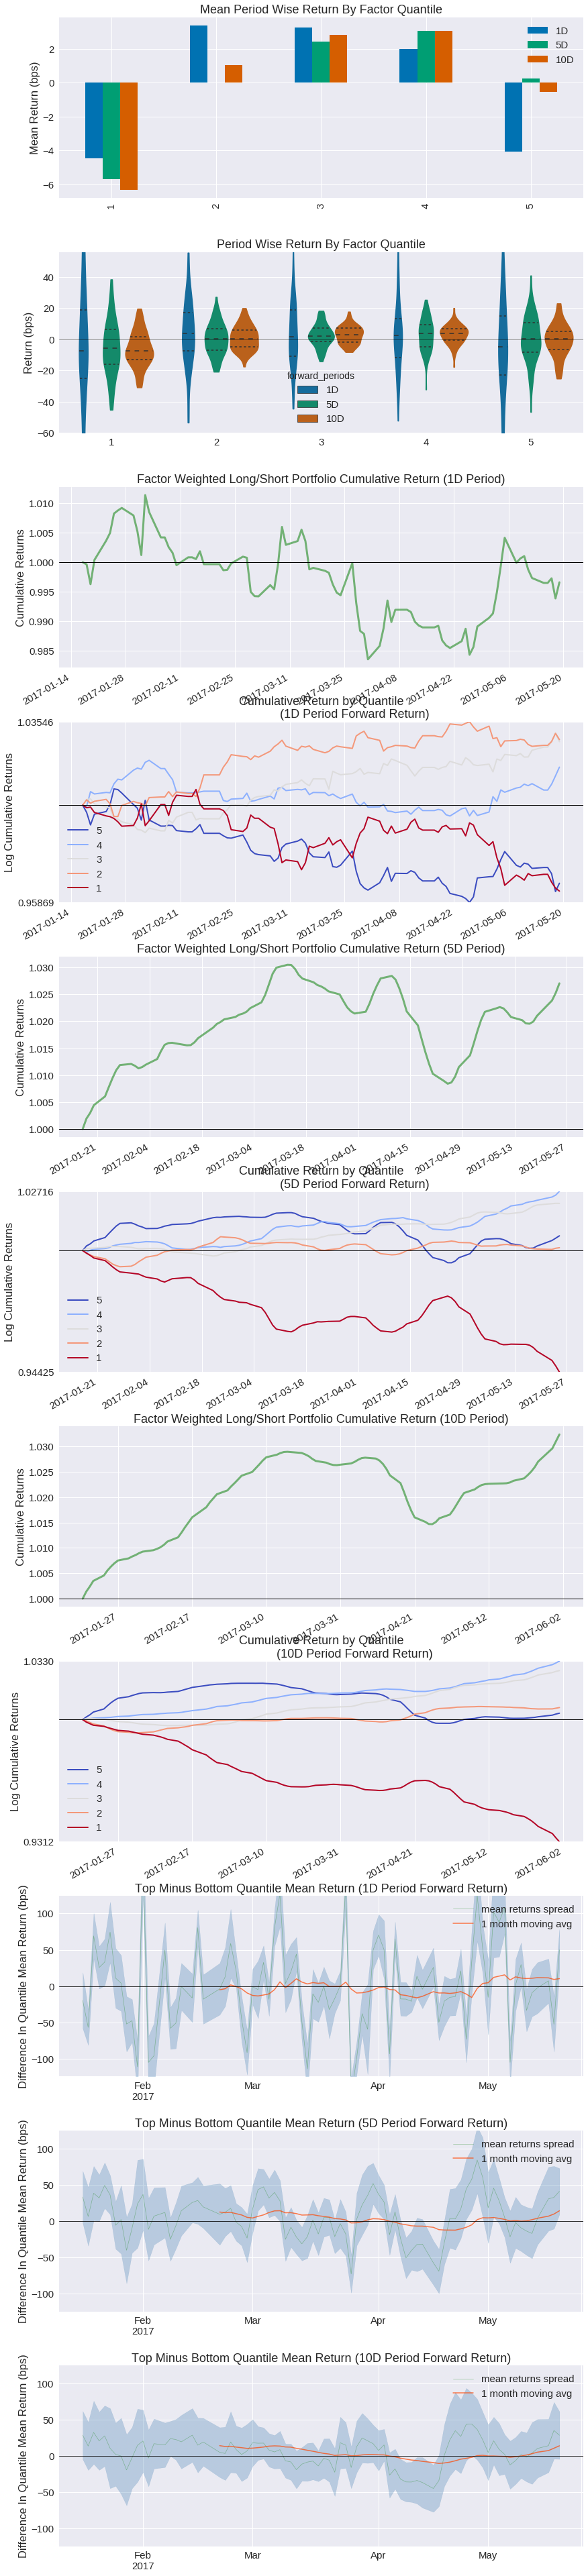

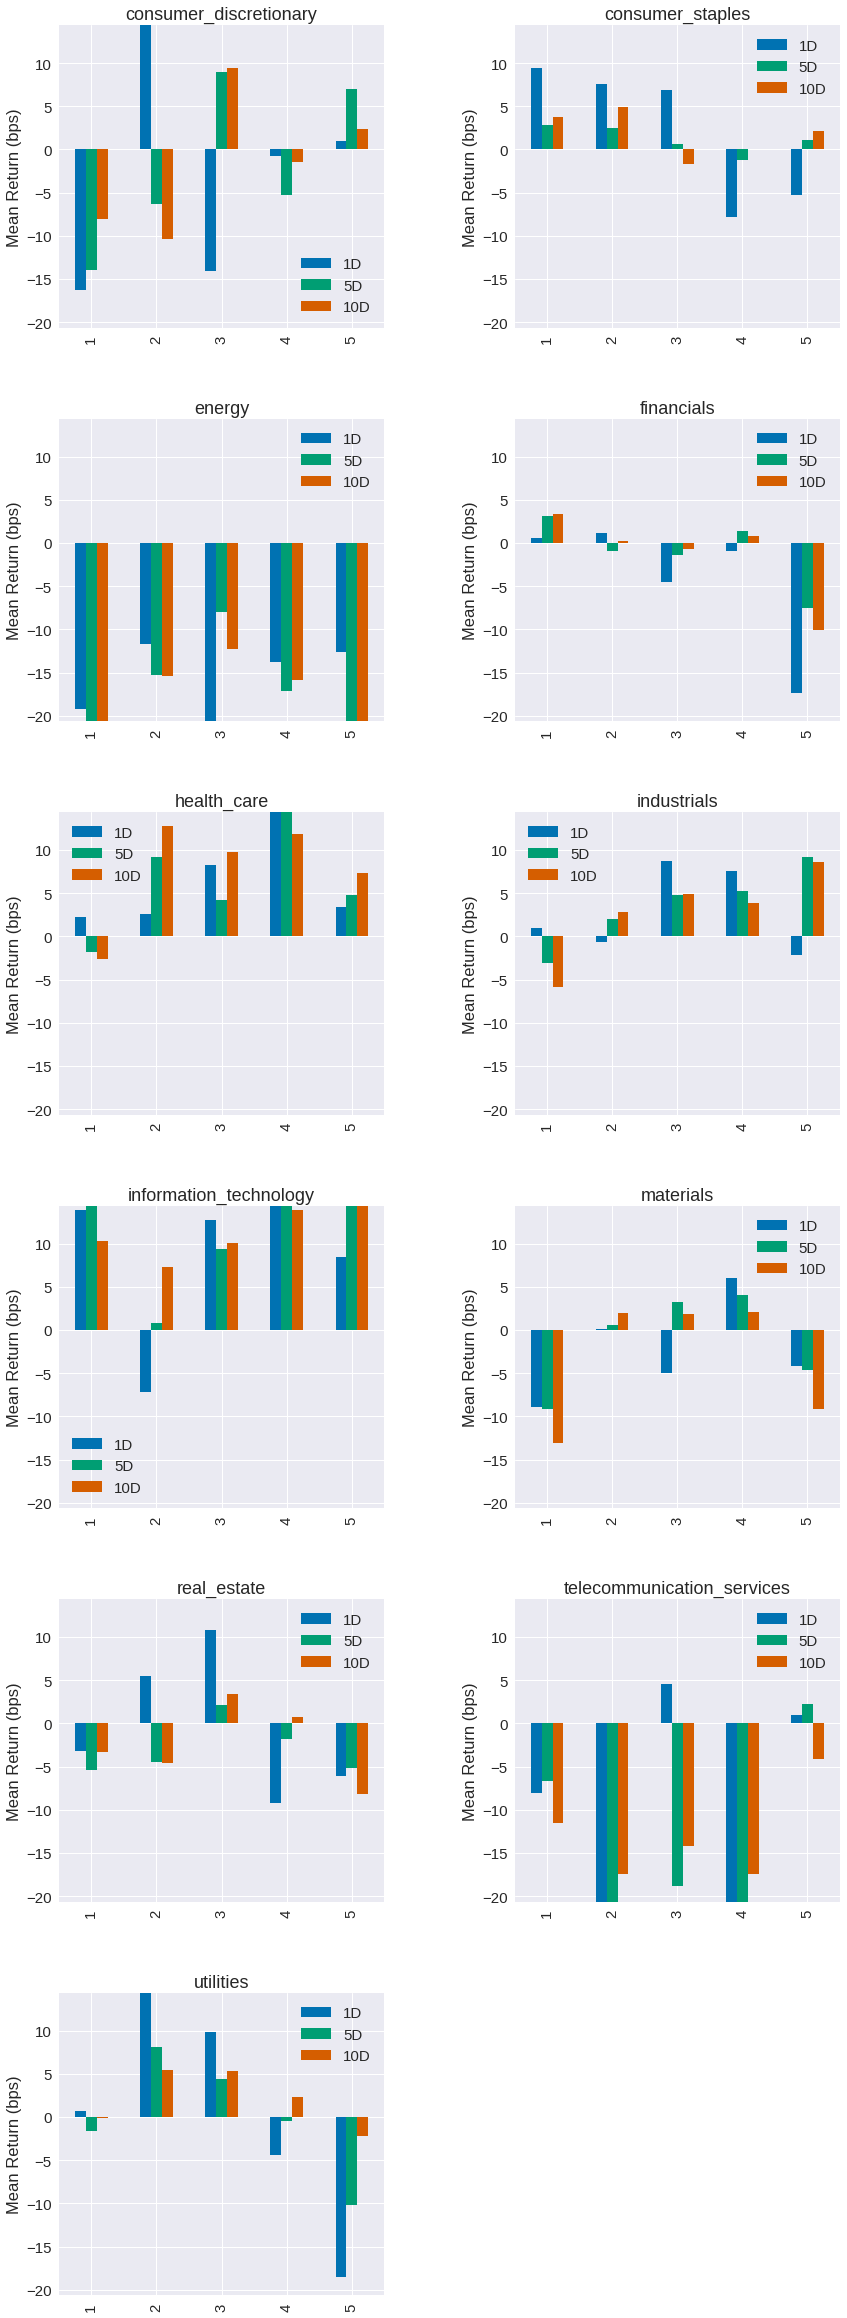

Information Analysis


,1D,5D,10D
IC Mean,-0.013,0.022,0.043
IC Std.,0.169,0.198,0.173
Risk-Adjusted IC,-0.075,0.114,0.248
t-stat(IC),-0.676,1.029,2.245
p-value(IC),0.501,0.307,0.027
IC Skew,-0.308,-0.406,-0.615
IC Kurtosis,0.430,-0.330,-0.614


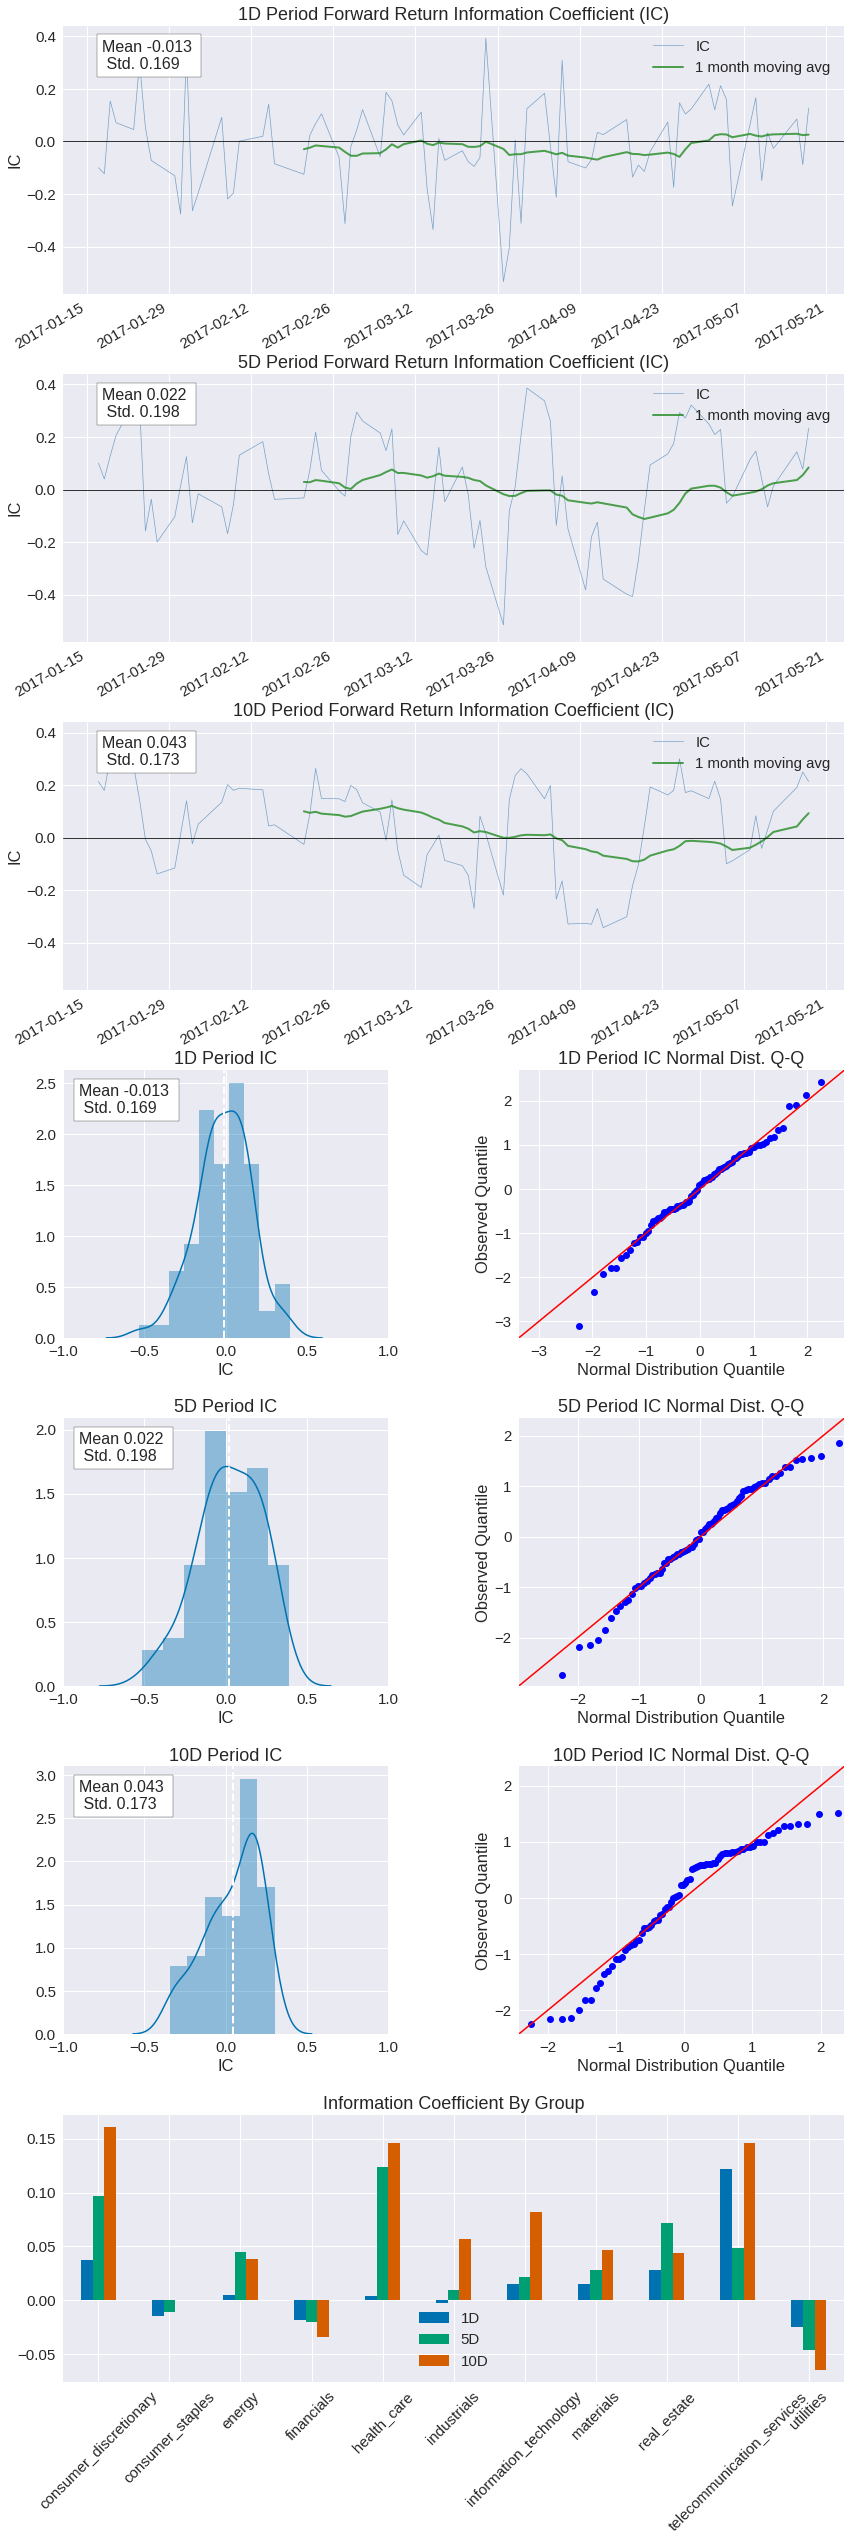

Turnover Analysis


,10D,1D,5D
Quantile 1 Mean Turnover,0.717,0.236,0.504
Quantile 2 Mean Turnover,0.804,0.504,0.741
Quantile 3 Mean Turnover,0.793,0.567,0.757
Quantile 4 Mean Turnover,0.774,0.505,0.731
Quantile 5 Mean Turnover,0.800,0.255,0.582


,1D,5D,10D
Mean Factor Rank Autocorrelation,0.855,0.441,0.045


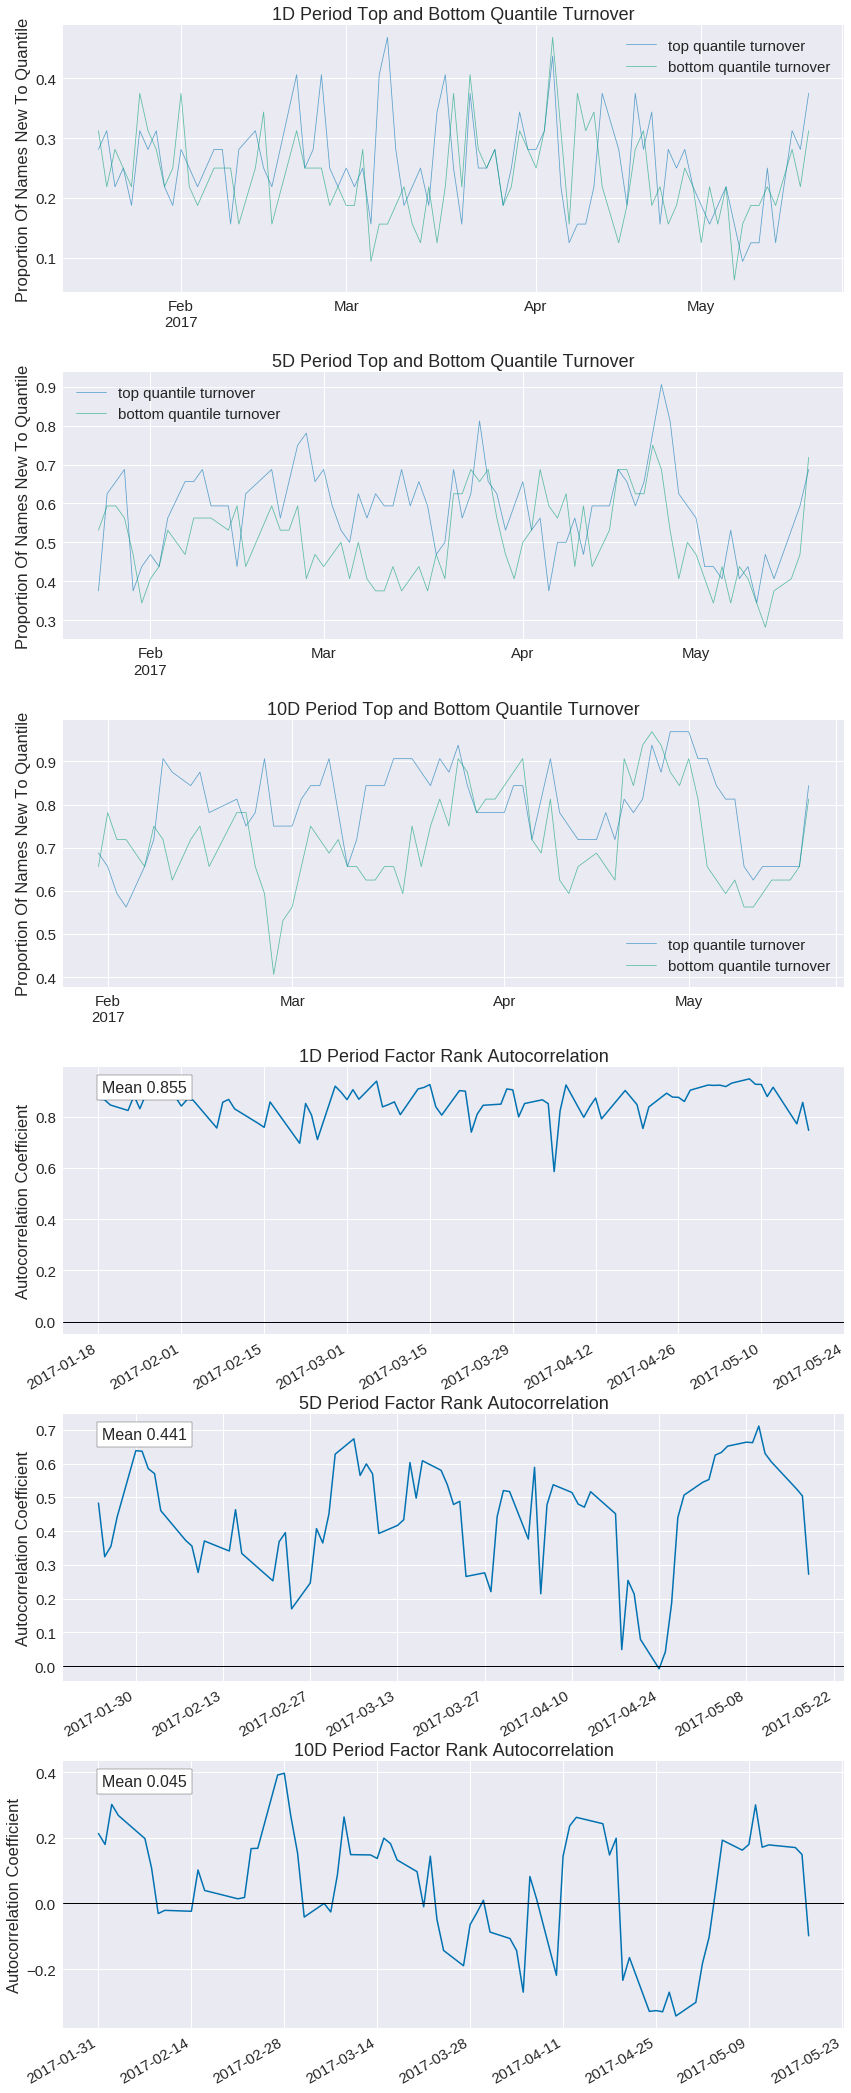

In [9]:
alphalens.tears.create_full_tear_sheet(non_predictive_factor_data, by_group=True)

# Run Alphalens on the predictive factor

In [10]:
predictive_factor_data = alphalens.utils.get_clean_factor_and_forward_returns(predictive_factor, 
                                                                              pricing, 
                                                                              quantiles=5,
                                                                              bins=None,
                                                                              groupby=ticker_sector,
                                                                              groupby_labels=sector_names)

Dropped 8.7% entries from factor data: 8.7% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-0.262200,0.009253,-0.033353,0.024418,2912,20.125786
2,-0.037797,0.019766,-0.007552,0.009132,2912,20.125786
3,-0.023201,0.026628,0.002891,0.008283,2821,19.496855
4,-0.011861,0.038359,0.013056,0.009104,2912,20.125786
5,-0.002438,0.325472,0.037946,0.026974,2912,20.125786


Returns Analysis


,1D,5D,10D
Ann. alpha,7.037,6.159,1.665
beta,-0.048,0.148,0.253
Mean Period Wise Return Top Quantile (bps),73.013,69.721,34.687
Mean Period Wise Return Bottom Quantile (bps),-75.716,-72.953,-38.435
Mean Period Wise Spread (bps),148.728,142.680,73.129


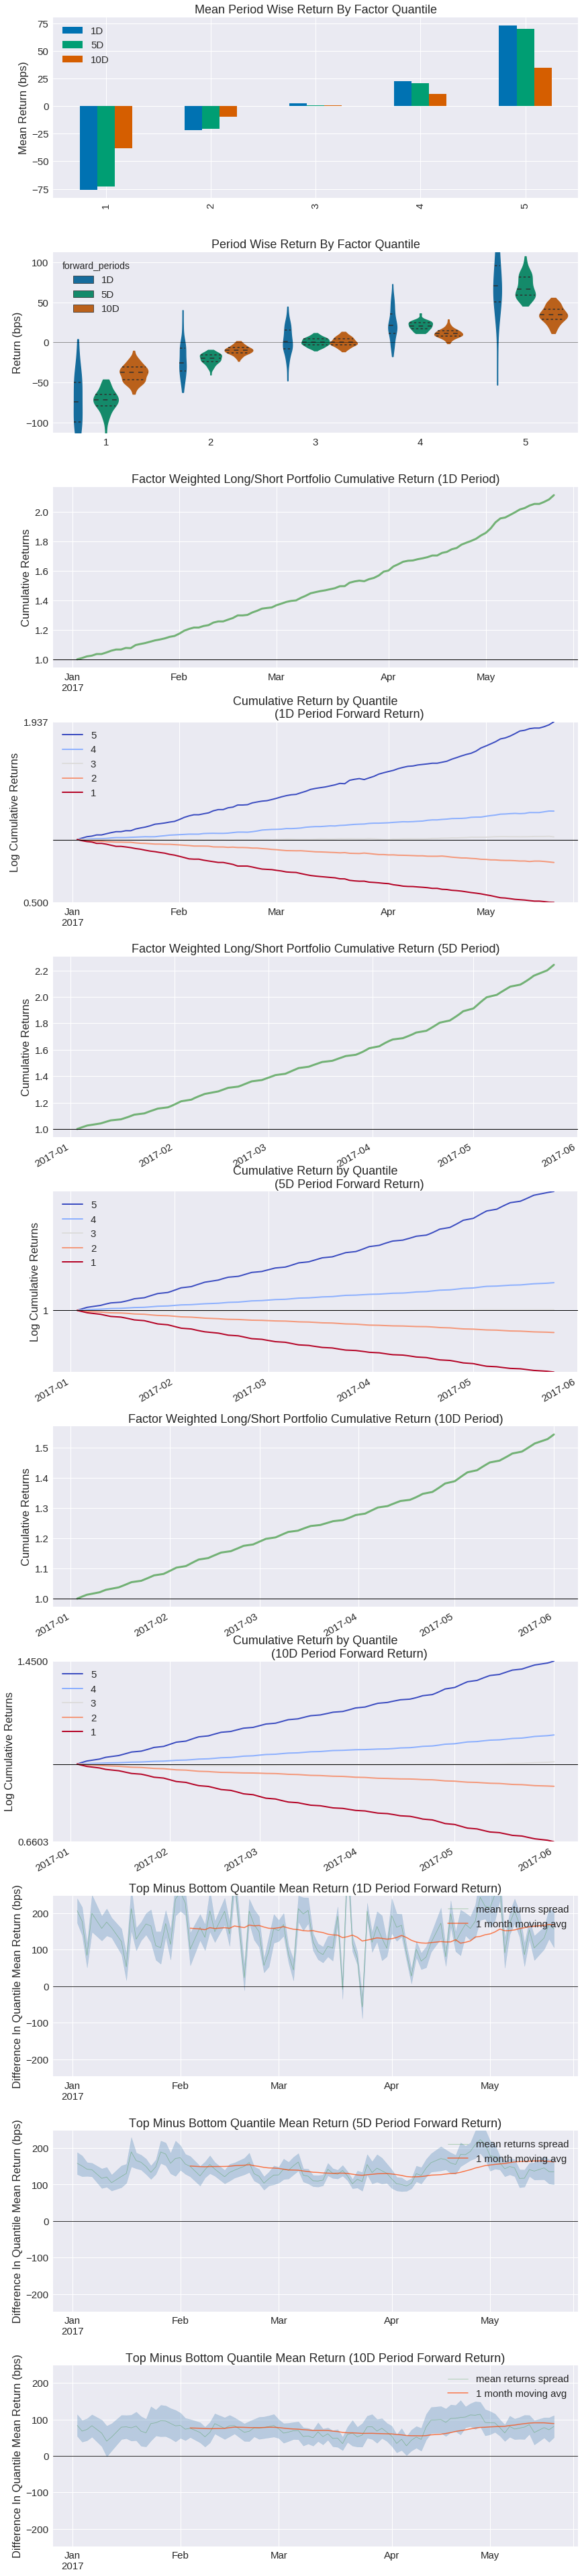

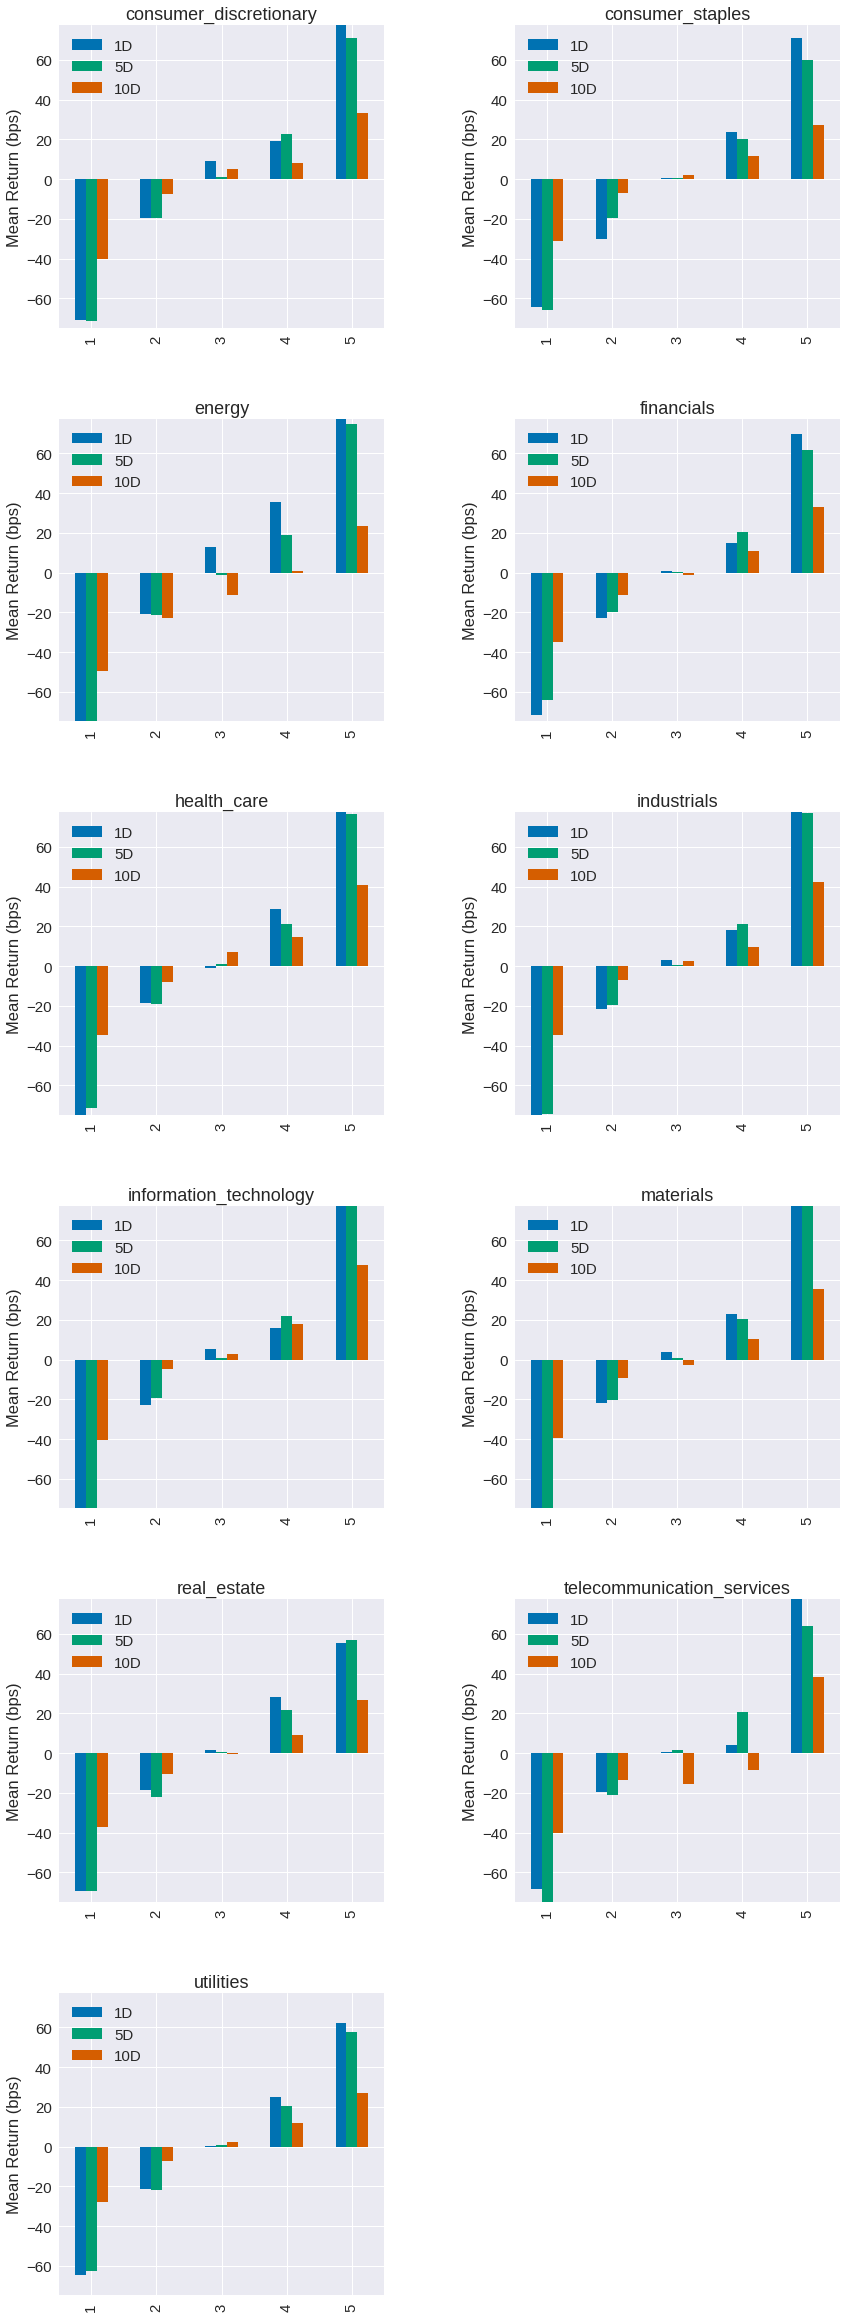

Information Analysis


,1D,5D,10D
IC Mean,0.416,1.000000,0.672
IC Std.,0.147,0.000000,0.104
Risk-Adjusted IC,2.824,inf,6.446
t-stat(IC),26.938,inf,61.487
p-value(IC),0.000,0.000000,0.000
IC Skew,-1.190,0.000000,-1.326
IC Kurtosis,3.134,-3.000000,1.711


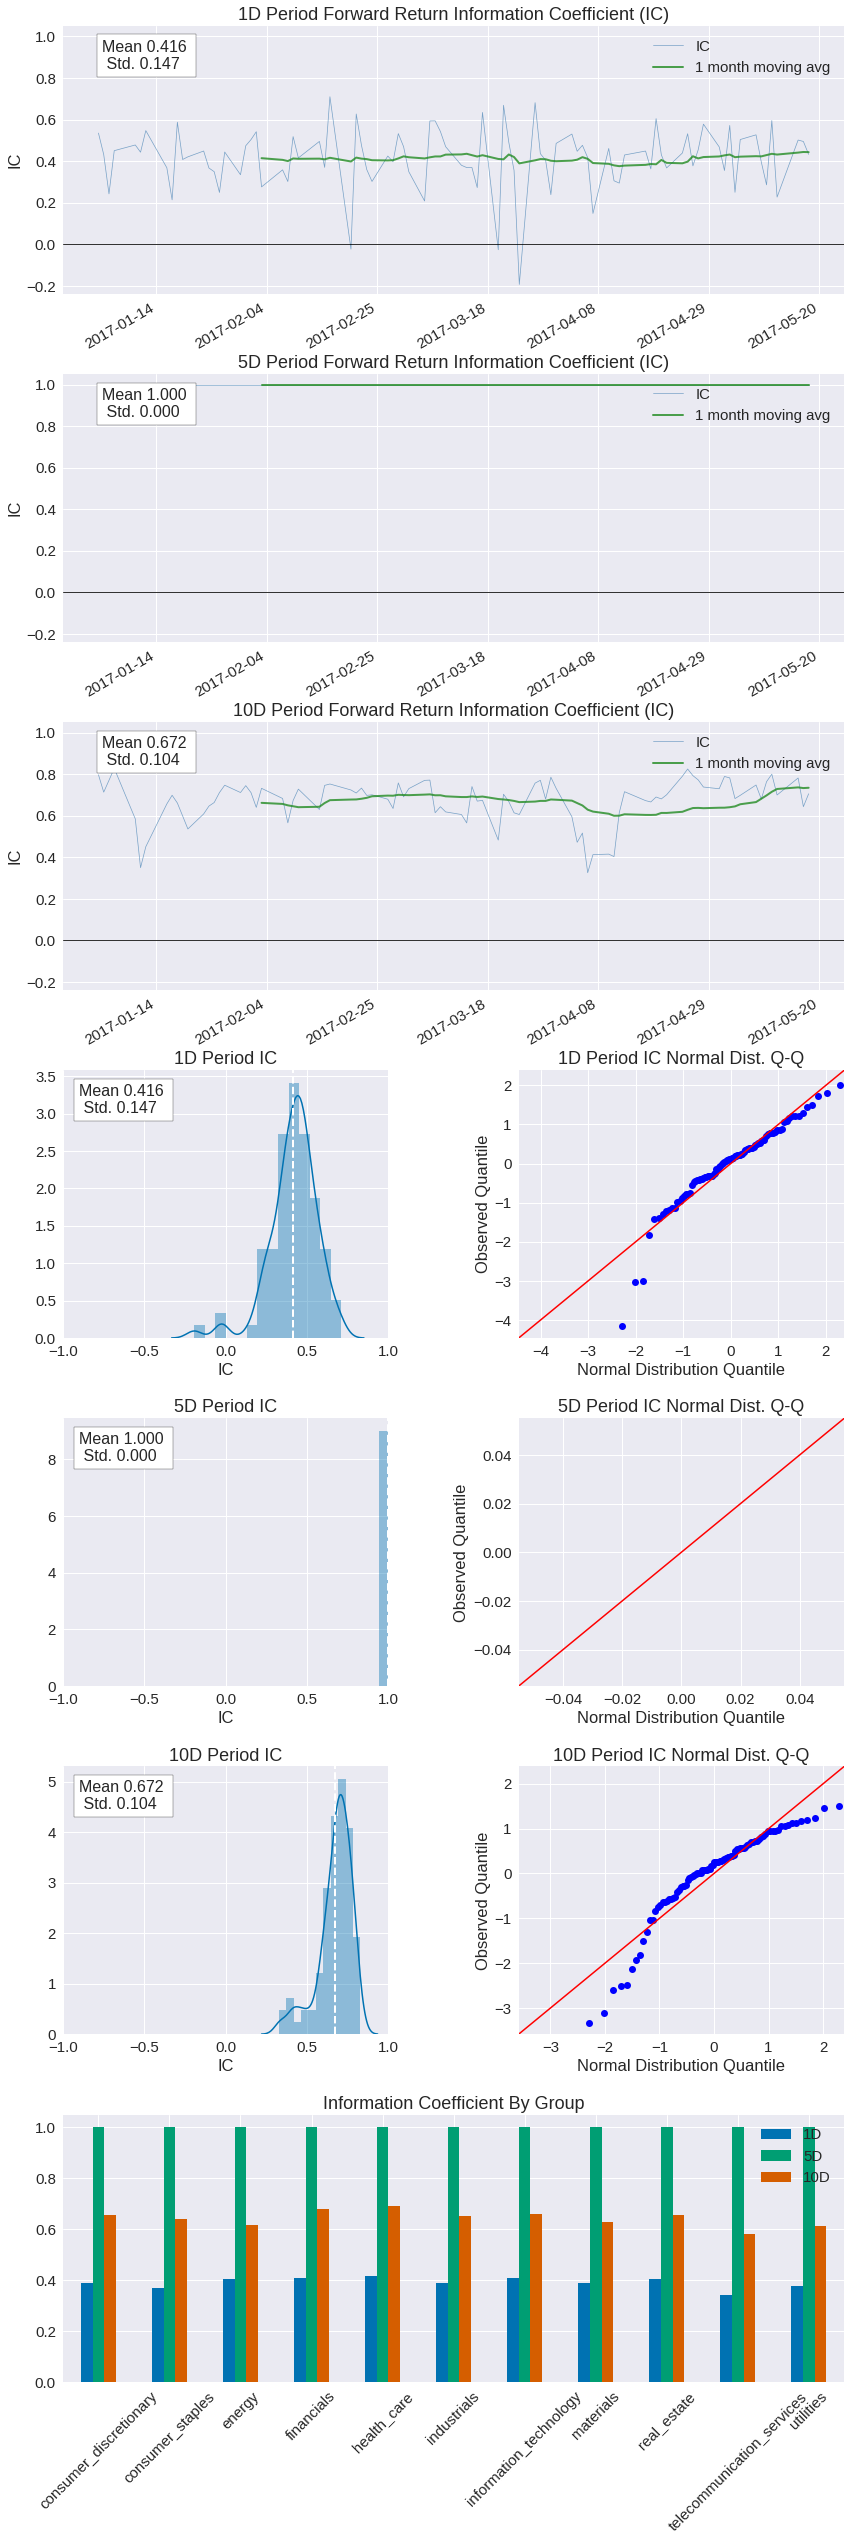

Turnover Analysis


,10D,1D,5D
Quantile 1 Mean Turnover,0.736,0.342,0.737
Quantile 2 Mean Turnover,0.799,0.610,0.803
Quantile 3 Mean Turnover,0.785,0.671,0.774
Quantile 4 Mean Turnover,0.797,0.615,0.792
Quantile 5 Mean Turnover,0.800,0.361,0.785


,1D,5D,10D
Mean Factor Rank Autocorrelation,0.736,0.0,0.032


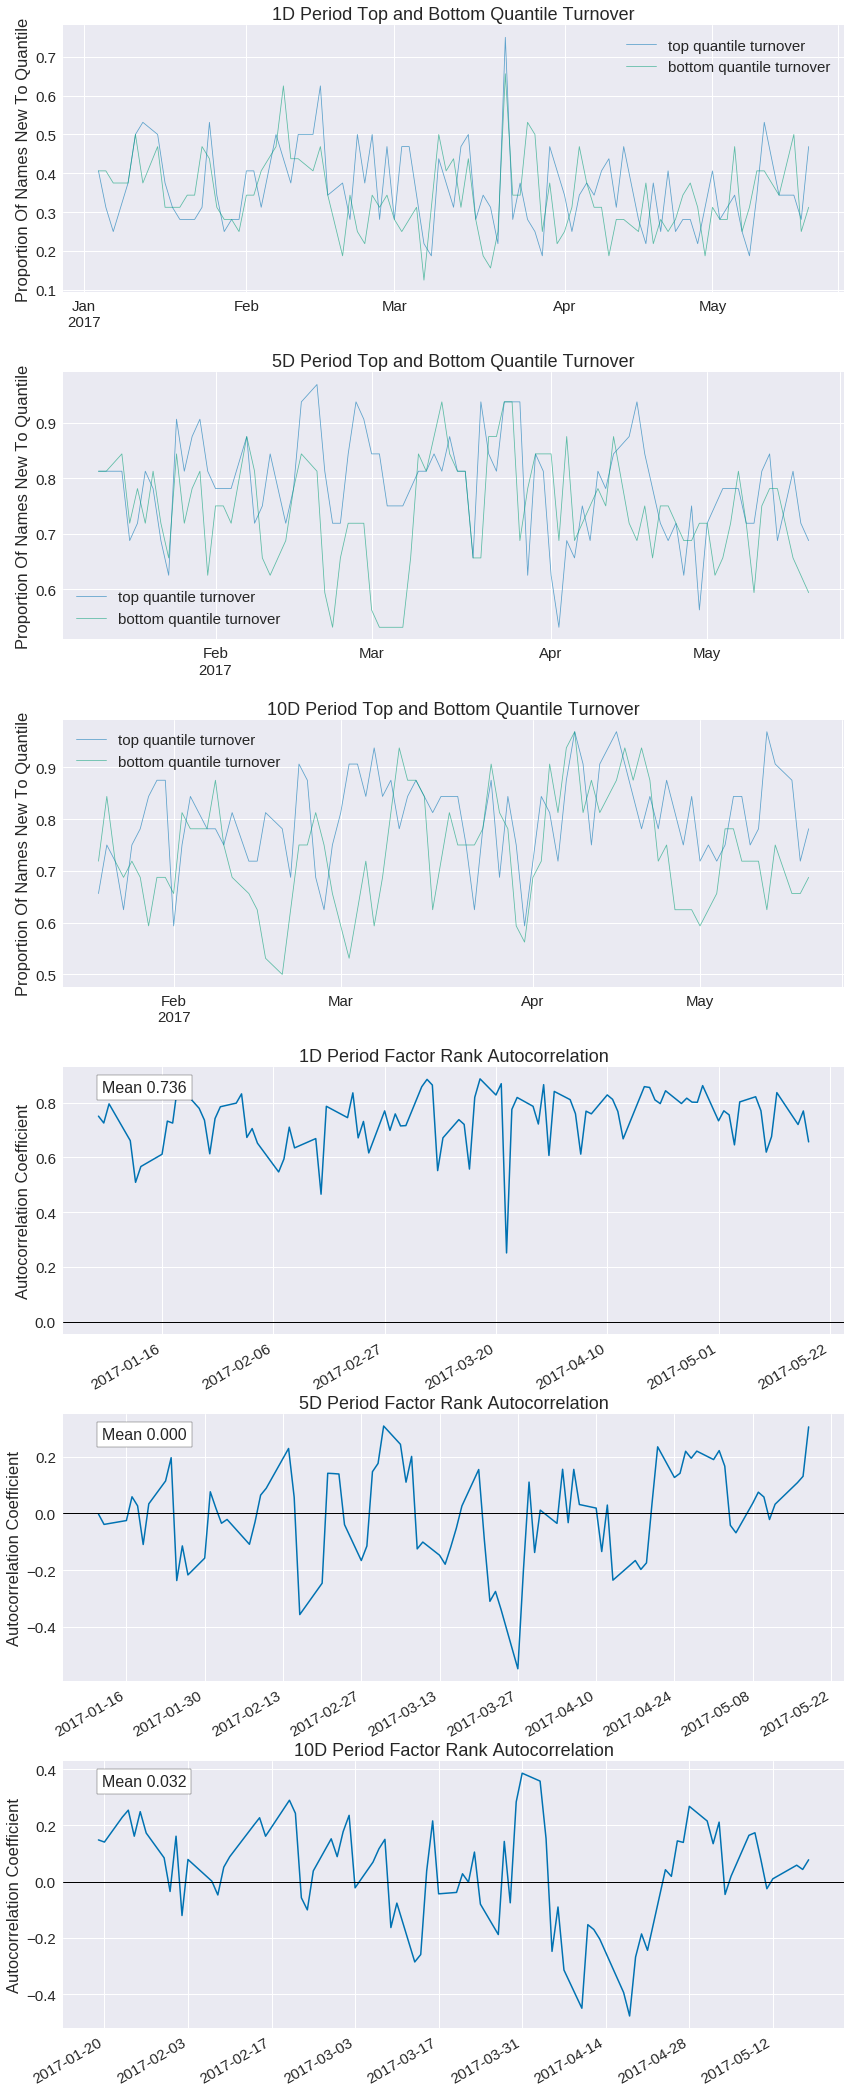

In [11]:
alphalens.tears.create_full_tear_sheet(predictive_factor_data, by_group=True)

# Run Event Style Returns Analysis

## Non-predictive factor

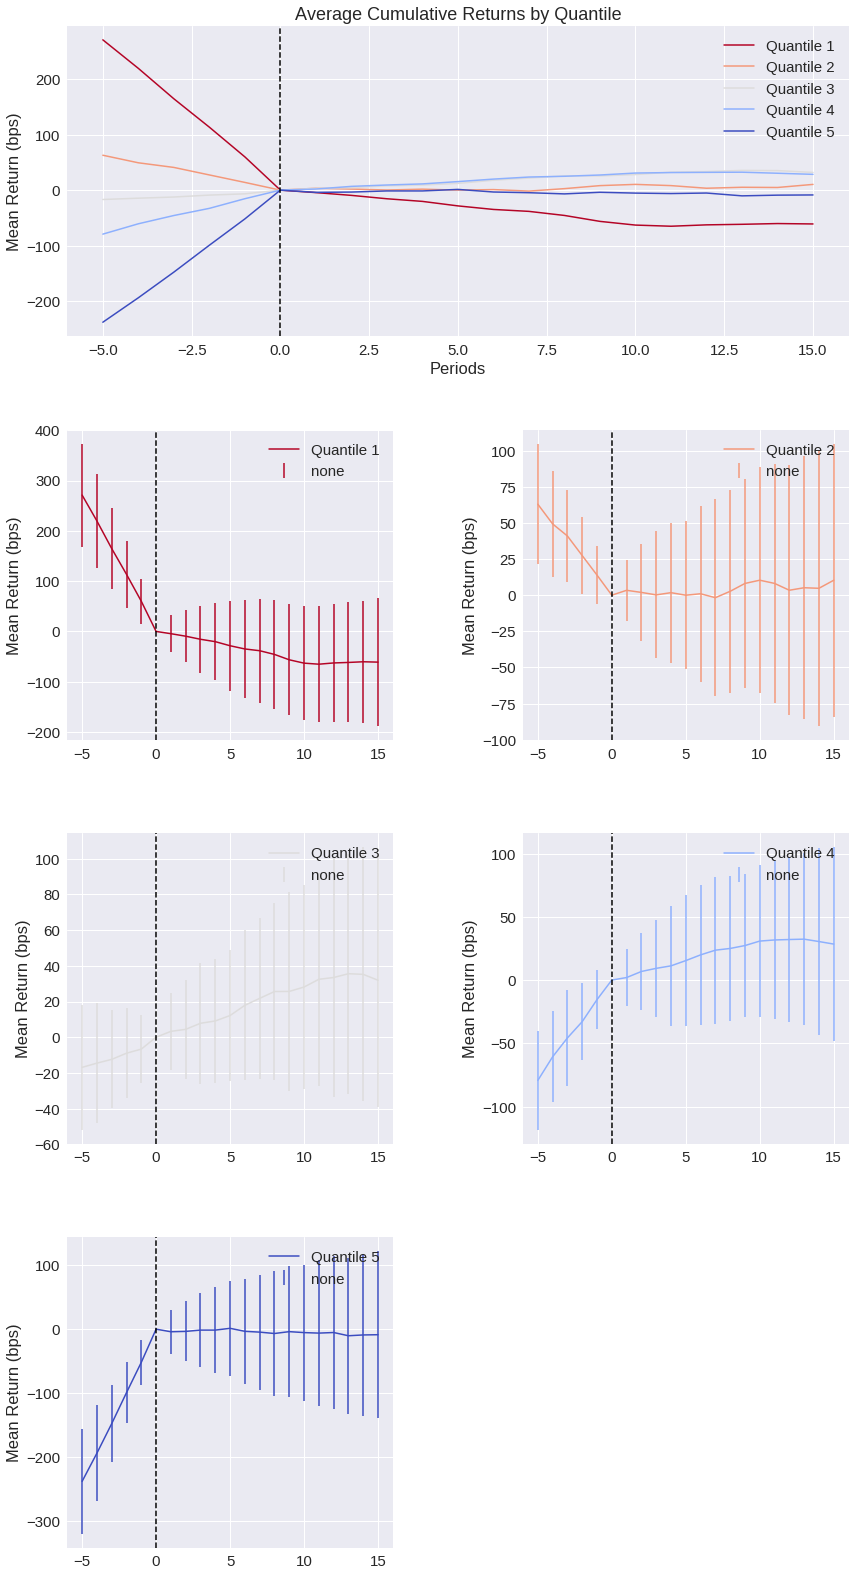

In [12]:
alphalens.tears.create_event_returns_tear_sheet(non_predictive_factor_data, pricing)

## Predictive factor

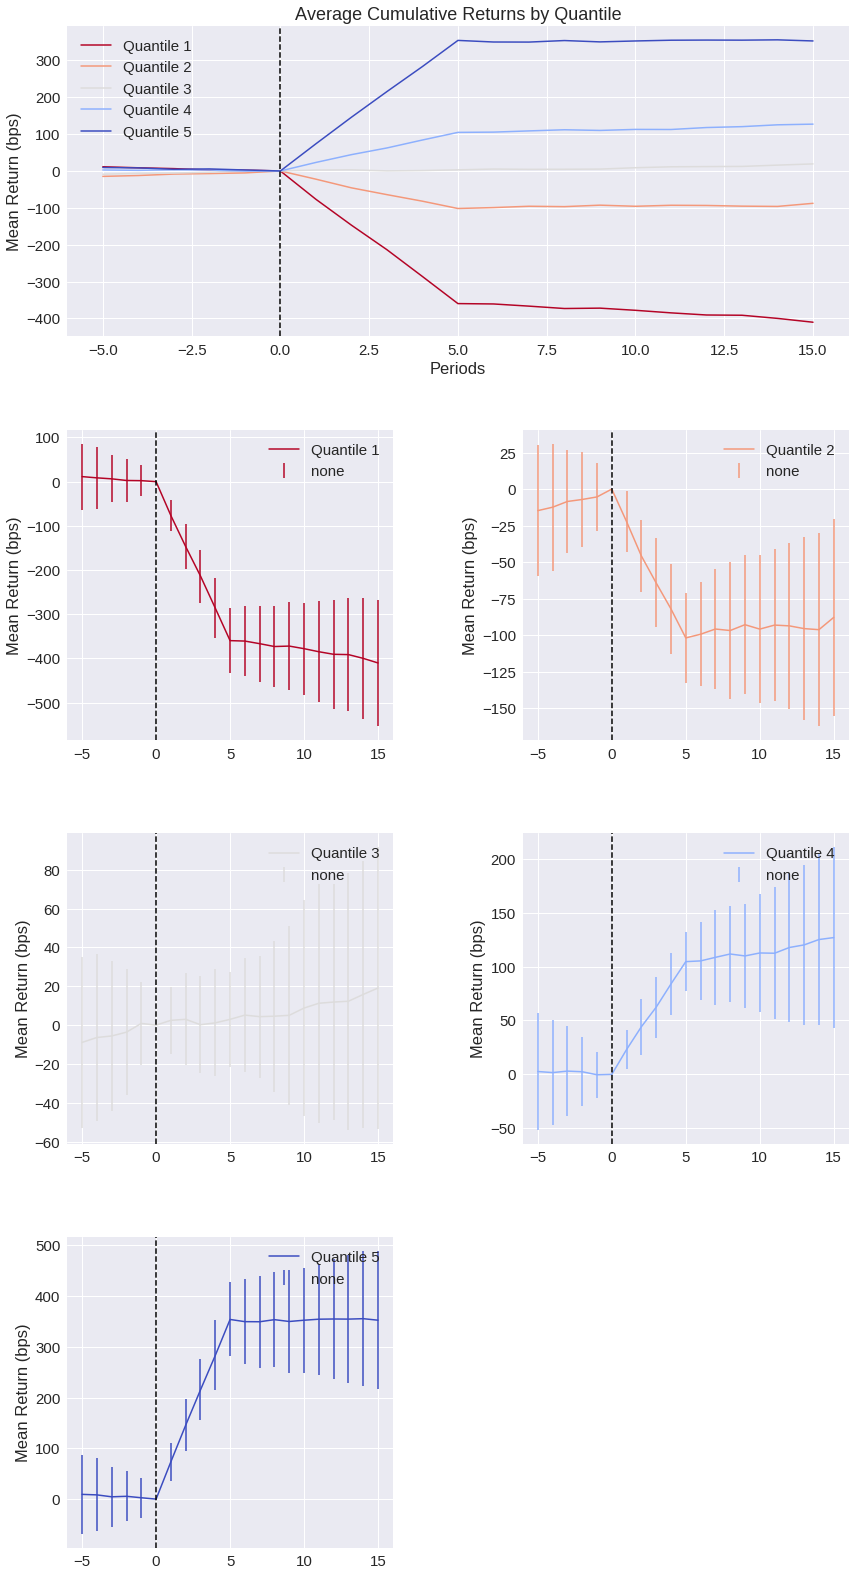

In [13]:
alphalens.tears.create_event_returns_tear_sheet(predictive_factor_data, pricing)